In [1]:
%matplotlib inline

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import neighbors
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy import interp

In [3]:
X_array = np.load('outputMatrix_userTrimmed.npz')
X = X_array['matrix']

In [4]:
# remove features with low variance (ie more than 80% samples have same value)
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_sel = sel.fit_transform(X)
X_sel.shape

(3047, 2838)

In [63]:
y_array = np.load('user_class_array.npz')
y_np = y_array['matrix']
y = y_np.tolist()[0]
y = label_binarize(y, classes=[0, 1, 2, 3, 4])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.1,
                                                    random_state=9)

In [102]:
svm_rbf = OneVsRestClassifier(svm.SVC(C=10, gamma=0.001, random_state=9)) # , probability=True))
y_score_rbf = svm_rbf.fit(X_train, y_train).decision_function(X_test)
#y_score_rbf = svm_rbf.fit(X_train, y_train).predict_proba(X_test)

In [98]:
y_score_rbf[:,0].shape

(305,)

In [99]:
y_test.shape

(305, 5)

In [108]:
# SVM_RBF
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
n_classes = 5
for i in range(n_classes):
#    scores = y_score_rbf[i]
#    name = "svm_class" + str(i)
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test[:, i], y_score_rbf[:, i])
#    fpr[name], tpr[name], _ = roc_curve(y_test[:, i], scores[:, 1])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

fpr_svm["micro"], tpr_svm["micro"], _ = roc_curve(y_test.ravel(), y_score_rbf.ravel())
roc_auc_svm["micro"] = auc(fpr_svm["micro"], tpr_svm["micro"])

In [117]:
print y_score_rbf.ravel().shape
print y_test.ravel().shape

(1525,)
(1525,)


In [110]:
roc_auc_svm

{0: 0.8947702347502946,
 1: 0.80727891156462595,
 2: 0.49009900990099009,
 3: 0.84984193888303483,
 4: 0.91464655810510731,
 'micro': 0.92090298306906748}

In [105]:
knn = neighbors.KNeighborsClassifier(19, metric='jaccard')
knn.fit(X_train, y_train)
y_score_knn = knn.predict_proba(X_test)

In [155]:
# knn
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    scores = y_score_knn[i]
#    name = "knn_class" + str(i)
#    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scores[:, i])
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test[:, i], scores[:, 1])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
scores_raveled_1 = y_score_knn[0][:, 1].ravel()
scores_raveled_2 = y_score_knn[1][:, 1].ravel()
scores_raveled_3 = y_score_knn[2][:, 1].ravel()
scores_raveled_4 = y_score_knn[3][:, 1].ravel()
scores_raveled_5 = y_score_knn[4][:, 1].ravel()

scores_raveled = np.concatenate((scores_raveled_1, scores_raveled_2))
scores_raveled = np.concatenate((scores_raveled, scores_raveled_3))
scores_raveled = np.concatenate((scores_raveled, scores_raveled_4))
scores_raveled = np.concatenate((scores_raveled, scores_raveled_5))

#scores_raveled = np.empty([1525,])
#for i in range(n_classes):
#   if i == 0:
#        scores_raveled = y_score_knn[1][:, 1].ravel()
#    else:
#        np.append(scores_raveled, y_score_knn[1][:, 1].ravel())

fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_test.ravel(), scores_raveled)
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

In [156]:
roc_auc_knn

{0: 0.83669446206834042,
 1: 0.76183673469387747,
 2: 0.68234323432343236,
 3: 0.67953108535300322,
 4: 0.89757586972612868,
 'micro': 0.50486159634506844}

In [152]:
y_test.shape

(305, 5)

In [120]:
scores_raveled.shape

AttributeError: 'list' object has no attribute 'shape'

In [56]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [57]:
roc_auc

{0: 0.8947702347502946,
 1: 0.80727891156462595,
 2: 0.49009900990099009,
 3: 0.84984193888303483,
 4: 0.91464655810510731,
 'macro': 0.79430156513180139,
 'micro': 0.92090298306906748}

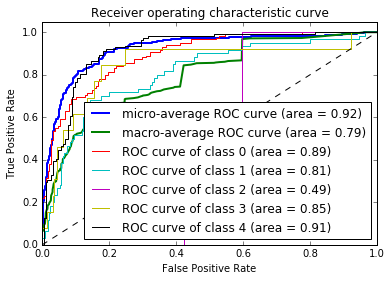

In [58]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()